# calling libraries

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
import os
import random
import tensorflow.keras as keras
# from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import pywt

import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.signal import butter, lfilter


In [2]:
from sklearn.metrics import mean_squared_error

# main functions

In [3]:
#This is for getting the same results.
def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)
reset_random_seeds(42)

In [4]:
# computing averages
def yy5(input_data):
    A=0
    B=0
    C=0
    D=0
    outputavg = []    
    for X in input_data:
        Y=(X+A+B+C+D)/5
        outputavg.append(Y)
        D=C
        C=B
        B=A
        A=X

    return outputavg

In [5]:
#construction of outputs
def output(inputdata):
    out=[]
    for i in range(7, len(inputdata)-1):
        out.append(inputdata[i+1])
    out = np.append(out, [np.nan])
    return out

In [6]:
#successive values 
def successive(successive):
   
    input_data=[]
    for i in range(7, len(successive)):
        input_data.append([successive[i-3]]+[successive[i-2]]+[successive[i-1]]+[successive[i]])
    return input_data  

In [7]:
#wavelet transform
def four_wavelets(training):
    input_data=np.array(training)
    days = input_data[:,0:4]
    

    for row in input_data:
            (a, d) = pywt.dwt(days, 'haar')
            (a2,d2)=pywt.dwt(a, 'haar') 
            l3=np.append(a2,d2, axis=1)
            l2_3=np.append(l3,d, axis=1)
            transformed_df=l2_3
    
    training=transformed_df
    
    
    return training

In [8]:
#network configurations
hidden1=32
second_layer1=32
third_layer1=32
forth_layer1=16

hidden2=32
second_layer2=32
third_layer2=32
forth_layer2=16

hidden3=32
second_layer3=32
third_layer3=32
forth_layer3=16

hidden4=32
second_layer4=32
third_layer4=32
forth_layer4=16

hidden5=32
second_layer5=32
third_layer5=32
forth_layer5=16

In [9]:
#calling input files
input_data=pd.read_csv('close_is.csv')
#input_data=pd.read_csv('open.csv')
#input_data=pd.read_csv('close.csv')
#input_data=pd.read_csv('min.csv')
#input_data=pd.read_csv('max.csv')

In [10]:
#construction of input arrays

input_data=np.array(input_data)
input_data=input_data.reshape(input_data.shape[0])
input_data=list(input_data)
input_data=np.array(input_data)


average=yy5(input_data)
input_data_average=successive(average)
input_data_successive=successive(input_data)
out=output(input_data)

In [11]:
#%matplotlib notebook

#fig,ax= plt.subplots()
#ax.plot(input_data, label='daily_input')
#ax.plot(average, label='average_input')
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
#plt.title('Input data')
#plt.show();



In [12]:
#division of data set into training and test data set
N=len( )
division_of_training=0.98
input_train=input_data_average[:int(N*division_of_training)]
input_test=input_data_average[int(N*division_of_training):int(N*1)]

successive_train=input_data_successive[:int(N*division_of_training)]
successive_test=input_data_successive[int(N*division_of_training):int(N*1)]
      
second_input_train=successive_train 
second_input_test=successive_test 

output_train= out[:int(N*division_of_training)]
output_test=out[int(N*division_of_training):int(N*1)]

In [13]:
#normalization

inputiavg=np.array(input_train)
inputiavgt=np.array(input_test)

inputsuc=np.array(second_input_train)
inputsuct=np.array(second_input_test)

subtraction_average_train=inputiavg
subtraction_average_test=inputiavgt

subtraction_successive_train=inputsuc
subtraction_successive_test=inputsuct

subtraction_average_train=subtraction_average_train.sum(axis=1)/4
subtraction_average_test=subtraction_average_test.sum(axis=1)/4

subtraction_successive_train=subtraction_successive_train.sum(axis=1)/4
subtraction_successive_test=subtraction_successive_test.sum(axis=1)/4

#normalization of inputs
first_input_train=input_train-subtraction_average_train[:, None]
first_input_test=input_test-subtraction_average_test[:,None]

output_train=output_train-subtraction_successive_train
output_test=output_test-subtraction_successive_test

second_input_train=second_input_train-subtraction_successive_train[:,None]
second_input_test=second_input_test-subtraction_successive_test[:,None]

# First NN, primary NN

In [14]:
#4inputs WT
final_first_w_input_train=four_wavelets(first_input_train)
final_first_w_input_test=four_wavelets(first_input_test)

X_train=np.array(final_first_w_input_train[:, 1:])
y_train=np.array(output_train)

X_test=np.array(final_first_w_input_test[:,1:])
y_test=np.array(output_test)

m_primary=len(X_train[0,:])
p_primary=np.size(y_train[0])
N_primary=len(X_train)

model= Sequential ([
    Dense(hidden1, input_dim=m_primary, activation='relu'), 
    Dropout(0.1),
    Dense(second_layer1), #,activation='relu'),
    Dropout(0.1),
    Dense(third_layer1), #,activation='relu'),
    Dropout(0.1),
    Dense(forth_layer1), #,activation='relu'),
    Dropout(0.1),
    Dense(p_primary)
    ])
    
model.summary()

sgd=keras.optimizers.SGD(learning_rate=0.05,momentum=0.75, decay=0.0, nesterov=False)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mean_absolute_error','mean_squared_logarithmic_error','cosine_similarity','logcosh'])
history1=model.fit(X_train, y_train, batch_size=N_primary, epochs=300, shuffle=False, verbose=0)  

predicted_train = model.predict(X_train) 
predicted_train = np.reshape(predicted_train, (predicted_train.size,))
error_train1=predicted_train-y_train

predicted_test = model.predict(X_test) 
predicted_test = np.reshape(predicted_test, (predicted_test.size,))
error_test1=predicted_test-y_test

2022-08-03 12:08:33.556287: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                128       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                5

# Second NN, error forecasting network 

In [15]:
error_train=pd.DataFrame(error_train1)
add_train=four_wavelets(second_input_train) 
   
X_error_train1=np.array(add_train[:, 1:])
y_error_train1=np.array(error_train)

error_test=pd.DataFrame(error_test1)
add_test=four_wavelets(second_input_test) 
  
X_error_test1=np.array(add_test[:, 1:])

m_second=len(X_error_train1[0,:])
p_second=np.size(y_train[0])
N_second=len(X_error_train1)

error_model1= Sequential ([
    Dense(hidden2, input_dim=m_second, activation='relu'), 
    Dropout(0.1),
    Dense(second_layer2), #,activation='relu'),
    Dropout(0.1),
    Dense(third_layer2), #,activation='relu'),
    Dropout(0.1),
    Dense(forth_layer2), #,activation='relu'),
    Dropout(0.1),
    Dense(p_second)
])

error_model1.summary()

sgd=keras.optimizers.SGD(learning_rate=0.05, momentum=0.75, decay=0.0, nesterov=False)
error_model1.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mse','mae','accuracy'])
history3=error_model1.fit(X_error_train1, y_error_train1, batch_size=N_second, epochs=300, shuffle=False, verbose=0)

error_predicted_tr = error_model1.predict(X_error_train1)
error_predicted_tr = np.reshape(error_predicted_tr, (error_predicted_tr.size,))
error_predicted_tes = error_model1.predict(X_error_test1)
error_predicted_tes = np.reshape(error_predicted_tes, (error_predicted_tes.size,))

compensated1_train=(predicted_train+subtraction_successive_train)-(error_predicted_tr)
compensated1_test=(predicted_test+subtraction_successive_test)-(error_predicted_tes)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                128       
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 16)               

# Third NN, error network 

In [16]:
error_train2a=compensated1_train-(y_train+subtraction_successive_train)
error_test2a=compensated1_test-(y_test+subtraction_successive_test)

error_train2=pd.DataFrame(error_train2a)
error_train2 [1]= error_train2[0].shift(1)
error_train2 [2]= error_train2[1].shift(1)
error_train2 [3]= error_train2[2].shift(1)
error_train2[4]= error_train2[3].shift(1)
error_train2 = error_train2.replace(np.nan, 0)
error_train2 = error_train2.iloc[:,::-1]
##error normalization
subtraction_error_train2=np.array(error_train2)
subtraction_error_train2=subtraction_error_train2[:,:-1]
subtraction_error_train2=subtraction_error_train2.sum(axis=1)/4

error_train2=error_train2-subtraction_error_train2[:, None]


error_train2=np.array(error_train2)
days_train = error_train2[:,:4]
input3_train=four_wavelets(days_train)
output3_train=error_train2[:,4]

X_error_train2=np.array(input3_train[:, 1:])
y_error_train2=np.array(output3_train)

error_test2=pd.DataFrame(error_test2a)
error_test2 [1]= error_test2[0].shift(1)
error_test2 [2]=error_test2[1].shift(1)
error_test2 [3]=error_test2[2].shift(1)
error_test2[4]=error_test2[3].shift(1)
error_test2 = error_test2.replace(np.nan, 0)
error_test2 = error_test2.iloc[:,::-1]

subtraction_error_test2=np.array(error_test2)
subtraction_error_test2=subtraction_error_test2[:,:-1]
subtraction_error_test2=subtraction_error_test2.sum(axis=1)/4

error_test2=error_test2-subtraction_error_test2[:,None]

error_test2=np.array(error_test2)
days_test = error_test2[:,:4]
input3_test=four_wavelets(days_test)
output3_test=error_test2[:,4]

X_error_test2=np.array(input3_test[:, 1:])


#####3rd NN
m_error=len(X_error_train2[0,:])
p_error=np.size(y_error_train2[0])
N_error=len(X_error_train2)


 
error_model2= Sequential ([
    Dense(hidden3, input_dim=m_error, activation='relu'), 
    Dropout(0.1),
    Dense(second_layer3), #,activation='relu'),
    Dropout(0.1),
    Dense(third_layer3), #,activation='relu'),
    Dropout(0.1),
    Dense(forth_layer3), #,activation='relu'),
    Dropout(0.1),
    Dense(p_error)
])

error_model2.summary()

sgd=keras.optimizers.SGD(learning_rate=0.05, momentum=0.75, decay=0.0, nesterov=False)
error_model2.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mse','mae','accuracy'])
history4=error_model2.fit(X_error_train2, y_error_train2, batch_size=N_error, epochs=300, shuffle=False, verbose=0)


error_predicted_tr2 = error_model2.predict(X_error_train2)
error_predicted_tr2 = np.reshape(error_predicted_tr2, (error_predicted_tr2.size,))
error_predicted_tes2 = error_model2.predict( X_error_test2)
error_predicted_tes2= np.reshape(error_predicted_tes2, (error_predicted_tes2.size,))

compensated_y_train=compensated1_train-(error_predicted_tr2+subtraction_error_train2)
compensated_y_test=compensated1_test-(error_predicted_tes2+subtraction_error_test2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 32)                128       
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 32)                1056      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)               

# Final NN 

In [17]:
error_predicted_tr3=error_predicted_tr2+subtraction_error_train2
error_predicted_tes3=error_predicted_tes2+subtraction_error_test2

training_final_add=np.column_stack((predicted_train, error_predicted_tr))
training_final_add=np.column_stack((training_final_add,error_predicted_tr3))

test_final_add=np.column_stack((predicted_test, error_predicted_tes))
test_final_add=np.column_stack((test_final_add,error_predicted_tes3))

####final NN
m_final=len(training_final_add[0,:])
p_final=np.size(y_train[0])
N_final=len(training_final_add)

final_model= Sequential ([
    Dense(hidden4, input_dim=m_final, activation='relu'), 
#    Dropout(0.1),
#    Dense(second_layer4), #,activation='relu'),
#    Dropout(0.1),
#    Dense(third_layer4), #,activation='relu'),
#    Dropout(0.1),
#    Dense(forth_layer4), #,activation='relu'),
#    Dropout(0.1),
    Dense(p_final)
])

final_model.summary()

sgd=keras.optimizers.SGD(learning_rate=0.05, momentum=0.75, decay=0.0, nesterov=False)
final_model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mse','mae','accuracy'])
final_history=final_model.fit(training_final_add, y_train, batch_size=N_final, epochs=300, shuffle=False, verbose=0)


final_predicted_tr =final_model.predict(training_final_add)
final_predicted_tr = np.reshape(final_predicted_tr, (final_predicted_tr.size,))
final_predicted_tes = final_model.predict(test_final_add)
final_predicted_tes = np.reshape(final_predicted_tes, (final_predicted_tes.size,))


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 32)                128       
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Final Network')

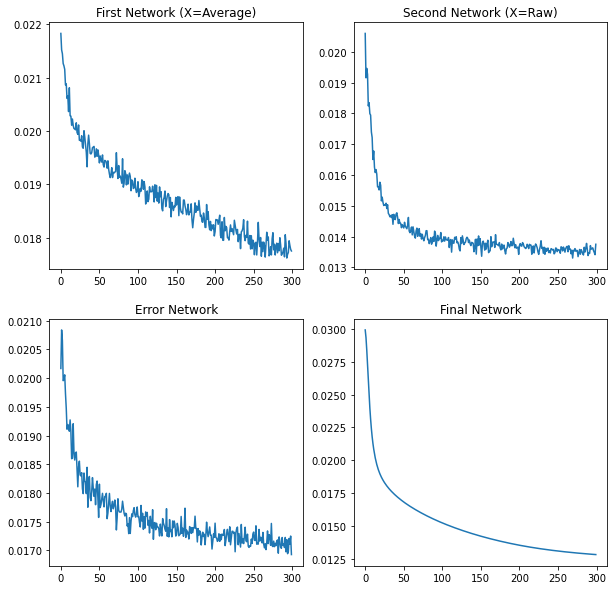

In [18]:
fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2, figsize=(10,10))
ax0.plot(history1.history["loss"])
ax0.set_title("First Network (X=Average)")

ax1.plot(history3.history["loss"])
ax1.set_title("Second Network (X=Raw)")

ax2.plot(history4.history["loss"])
ax2.set_title("Error Network")

ax3.plot(final_history.history["loss"])
ax3.set_title("Final Network")

# errors

In [19]:
y_train=y_train+subtraction_successive_train
final_y_train=final_predicted_tr+subtraction_successive_train
final_y_train = np.reshape(final_y_train, (final_y_train.size,))

final_error_train=final_y_train-y_train
final_rmse_error_train=np.sqrt(sum(final_error_train*final_error_train)/len(final_error_train))
final_mse_train=(sum(final_error_train*final_error_train)/len(final_error_train))
final_mape_train=100*sum(abs(final_error_train/y_train))/len(y_train)
final_mae_train=sum(abs(final_error_train-y_train))/len(y_train)
final_rmspe_train=100*np.sqrt(np.nanmean(np.square(((y_train - final_y_train) / y_train))))

 
y_test=y_test+subtraction_successive_test
 
final_y_test=final_predicted_tes+subtraction_successive_test
y_test = np.reshape(y_test, (y_test.size,))
final_y_test = np.reshape(final_y_test, (final_y_test.size,))


#final_error_test=y_test[:-1]-final_predicted_tes[:-1]
final_error_test=final_y_test[:-1]-y_test[:-1] 
final_rmse_error_test=np.sqrt(sum(final_error_test*final_error_test)/len(final_error_test))
final_mse_test=(sum(final_error_test*final_error_test)/len(final_error_test))
final_mape_test=100*sum(abs(final_error_test/y_test[:-1]))/len(y_test-1)
final_mae_test=sum(abs(final_error_test-y_test[:-1]))/len(y_test-1)
final_rmspe_test=100*np.sqrt(np.nanmean(np.square(((y_test[:-1] - final_y_test[:-1]) / y_test[:-1]))))

#errors of the first nn
predicted_train=predicted_train+subtraction_successive_train
predicted_test=predicted_test+subtraction_successive_test

predicted_error_train=predicted_train-y_train
predicted_rmse_error_train=np.sqrt(sum(predicted_error_train*predicted_error_train)/len(predicted_error_train))
predicted_mse_train=(sum(predicted_error_train*predicted_error_train)/len(predicted_error_train))
predicted_mape_train=100*sum(abs(predicted_error_train/y_train))/len(y_train)
predicted_mae_train=sum(abs(predicted_error_train-y_train))/len(y_train)
predicted_rmspe_train=100*np.sqrt(np.nanmean(np.square(((y_train - predicted_train) / y_train))))

predicted_error_test=predicted_test[:-1]-y_test[:-1]
predicted_rmse_error_test=np.sqrt(sum(predicted_error_test*predicted_error_test)/len(predicted_error_test))
predicted_mse_test=(sum(predicted_error_test*predicted_error_test)/len(predicted_error_test))
predicted_mape_test=100*sum(abs(predicted_error_test/y_test[:-1]))/len(y_test-1)
predicted_mae_test=sum(abs(predicted_error_test-y_test[:-1]))/len(y_test-1)
predicted_rmspe_test=100*np.sqrt(np.nanmean(np.square(((y_test[:-1] - predicted_test[:-1]) / y_test[:-1]))))

#errors of the second nn
compensated1_train_error=compensated1_train-y_train

compensated1_train_rmse_error_train=np.sqrt(sum(compensated1_train_error*compensated1_train_error)/len(compensated1_train_error))
compensated1_train_mse_train=(sum(compensated1_train_error*compensated1_train_error)/len(compensated1_train_error))
compensated1_train_mape_train=100*sum(abs(compensated1_train_error/y_train))/len(y_train)
compensated1_train_mae_train=sum(abs(compensated1_train_error-y_train))/len(y_train)
compensated1_train_rmspe_train=np.sqrt(np.nanmean(np.square(((y_train - compensated1_train) / y_train))))*100

compensated1_test_error=compensated1_test[:-1]-y_test[:-1]

compensated1_test_rmse_error_test=np.sqrt(sum(compensated1_test_error*compensated1_test_error)/len(compensated1_test_error))
compensated1_test_mse_test=(sum(compensated1_test_error*compensated1_test_error)/len(compensated1_test_error))
compensated1_test_mape_test=100*sum(abs(compensated1_test_error/y_test[:-1]))/len(y_test-1)
compensated1_test_mae_test=sum(abs(compensated1_test_error-y_test[:-1]))/len(y_test-1)
compensated1_test_rmspe_test=np.sqrt(np.nanmean(np.square(((y_test[:-1] - compensated1_test[:-1]) / y_test[:-1]))))*100

#errors of the third nn
compensated_error_train=compensated_y_train-y_train

comp_rmse_error_train=np.sqrt(sum(compensated_error_train*compensated_error_train)/len(compensated_error_train))
comp_mse_train=(sum(compensated_error_train*compensated_error_train)/len(compensated_error_train))
comp_mape_train=100*sum(abs(compensated_error_train/y_train))/len(y_train)
comp_mae_train=sum(abs(compensated_error_train-y_train))/len(y_train)
comp_rmspe_train=np.sqrt(np.nanmean(np.square(((y_train - compensated_y_train) / y_train))))*100

compensated_error_test=compensated_y_test[:-1]-y_test[:-1]

comp_rmse_error_test=np.sqrt(sum(compensated_error_test*compensated_error_test)/len(compensated_error_test))
comp_mse_test=(sum(compensated_error_test*compensated_error_test)/len(compensated_error_test))
comp_mape_test=100*sum(abs(compensated_error_test/y_test[:-1]))/len(y_test-1)
comp_mae_test=sum(abs(compensated_error_test-y_test[:-1]))/len(y_test-1)
comp_rmspe_test=np.sqrt(np.nanmean(np.square(((y_test[:-1] - compensated_y_test[:-1]) / y_test[:-1]))))*100


In [20]:
zz_rmse_errors_ttrain=(predicted_rmse_error_train,compensated1_train_rmse_error_train, comp_rmse_error_train,final_rmse_error_train)
zz_rmse_errors_test=(predicted_rmse_error_test,compensated1_test_rmse_error_test, comp_rmse_error_test,final_rmse_error_test)

zz_rmspe_errors_ttrain=(predicted_rmspe_train,compensated1_train_rmspe_train, comp_rmspe_train,final_rmspe_train)
zz_rmspe_errors_test=(predicted_rmspe_test,compensated1_test_rmspe_test, comp_rmspe_test,final_rmspe_test)

zz_mape_errors_ttrain=(predicted_mape_train,compensated1_train_mape_train, comp_mape_train,final_mape_train)
zz_mape_errors_test=(predicted_mape_test,compensated1_test_mape_test, comp_mape_test,final_mape_test)

zz_mae_errors_ttrain=(predicted_mae_train,compensated1_train_mae_train, comp_mae_train,final_mae_train)
zz_mae_errors_test=(predicted_mae_test,compensated1_test_mae_test, comp_mae_test,final_mae_test)

zz_predictions_train = (y_train, predicted_train,compensated1_train,  compensated_y_train, final_y_train)
zz_predictions_test = (y_test,predicted_test,compensated1_test, compensated_y_test, final_y_test)


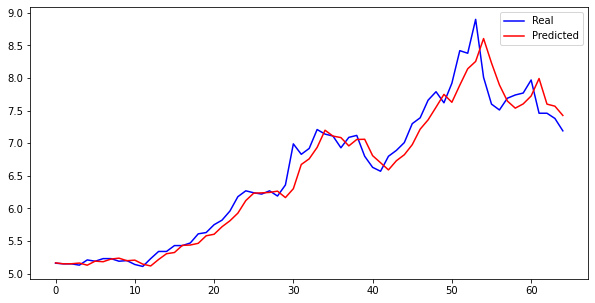

In [21]:
plt.figure(figsize=(10,5))
plt.plot(y_test[:-1], c='b', label="Real")
plt.plot(final_y_test[:-1], c='r', label="Predicted")
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test[:-1], final_y_test[:-1],  squared=False)

0.23852133331195127

In [23]:
#tomorrows prediction
final_y_test[-1]

7.162397352457047